In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os
import cv2
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [23]:
class MCNN(nn.Module):
    def __init__(self):
        super(MCNN, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 16, 9, padding=4), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 7, padding=3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 7, padding=3), nn.ReLU(),
            nn.Conv2d(16, 8, 7, padding=3), nn.ReLU()
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(3, 20, 7, padding=3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(20, 40, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(40, 20, 5, padding=2), nn.ReLU(),
            nn.Conv2d(20, 10, 5, padding=2), nn.ReLU()
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(3, 24, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(24, 48, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(48, 24, 3, padding=1), nn.ReLU(),
            nn.Conv2d(24, 12, 3, padding=1), nn.ReLU()
        )
        self.fuse = nn.Conv2d(8 + 10 + 12, 1, 1)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        return self.fuse(torch.cat((x1, x2, x3), dim=1))


In [24]:
class ShanghaiTechCrowdCountingDataset(Dataset):
    def __init__(self, image_dir, gt_dir, transform=None, img_size=(64, 64)):
        self.image_dir = image_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.img_size = img_size
        self.image_files = sorted(os.listdir(image_dir))
        self.gt_files = sorted(os.listdir(gt_dir))

    def __len__(self):
        return len(self.image_files)

    def generate_density_map(self, img, coordinates):
        density_map = np.zeros(img.shape[:2], dtype=np.float32)
        kernel_size = 15
        sigma = 4.0
        for coord in coordinates:
            x, y = int(coord[0]), int(coord[1])
            gaussian_kernel = self.create_gaussian_kernel(kernel_size, sigma)
            x_min = max(x - kernel_size // 2, 0)
            y_min = max(y - kernel_size // 2, 0)
            x_max = min(x + kernel_size // 2, img.shape[1])
            y_max = min(y + kernel_size // 2, img.shape[0])
            if x_max > x_min and y_max > y_min:
                density_map[y_min:y_max, x_min:x_max] += gaussian_kernel[:y_max - y_min, :x_max - x_min]
        return np.clip(density_map, 0, 255)

    def create_gaussian_kernel(self, kernel_size, sigma):
        ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        return kernel / np.sum(kernel)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_files[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mat_data = loadmat(gt_path)
        coordinates = mat_data['image_info'][0, 0]['location'][0, 0]
        density_map = self.generate_density_map(image, coordinates)
        image = cv2.resize(image, self.img_size)
        density_map = cv2.resize(density_map, self.img_size)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        density_map = torch.tensor(density_map, dtype=torch.float32).unsqueeze(0)
        return image, density_map


In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ShanghaiTechCrowdCountingDataset(
    image_dir='ShanghaiTech/part_B_final/train_data/images',
    gt_dir='ShanghaiTech/part_B_final/train_data/ground_truth',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = ShanghaiTechCrowdCountingDataset(
    image_dir='ShanghaiTech/part_B_final/test_data/images',
    gt_dir='ShanghaiTech/part_B_final/test_data/ground_truth',
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)



In [26]:
def count_people_from_density(density_map):
    return float(density_map.sum().item())


In [27]:
def plot(img, gt, pred):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt.squeeze().cpu(), cmap='jet')
    plt.title(f"Ground Truth: {gt.sum().item():.1f} People")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred.squeeze(), cmap='jet')
    plt.title(f"Predicted: {pred.sum():.1f} People")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [28]:
import matplotlib.pyplot as plt

def visualize_counting_result(image, gt_map, pred_map, gt_count, pred_count):
    """
    Plots the input image, ground truth density map, and predicted density map.
    Also displays the true and predicted crowd counts.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image.permute(1, 2, 0).cpu())  # Tensor CHW to HWC
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    axs[1].imshow(gt_map.squeeze().cpu(), cmap='jet')
    axs[1].set_title(f"GT Count: {gt_count:.1f}")
    axs[1].axis('off')

    axs[2].imshow(pred_map.squeeze().detach().cpu(), cmap='jet')
    axs[2].set_title(f"Predicted Count: {pred_count:.1f}")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


Epoch 1: Loss = 0.0005


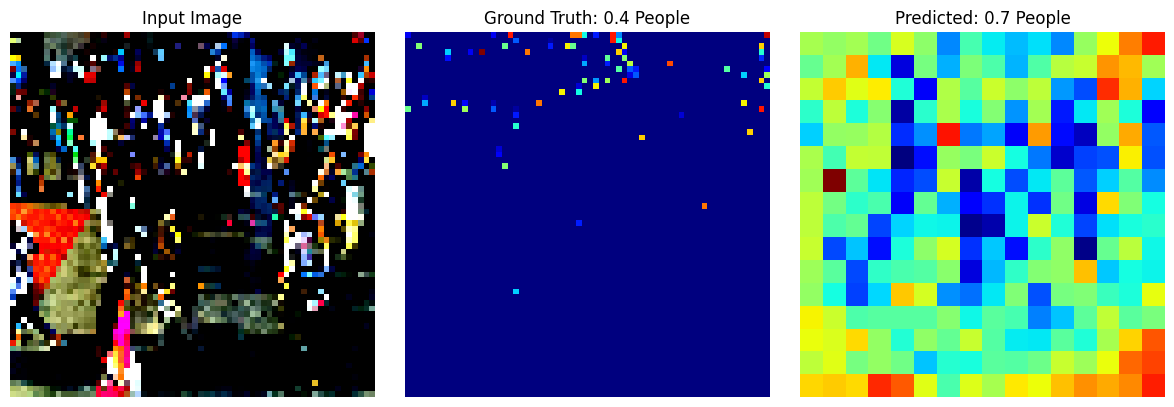

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].


Epoch 2: Loss = 0.0002


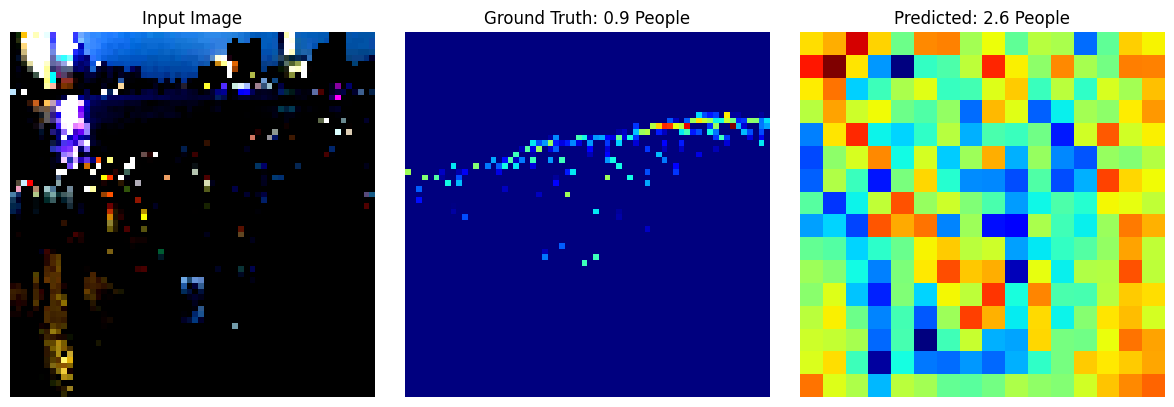

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


Epoch 3: Loss = 0.0001


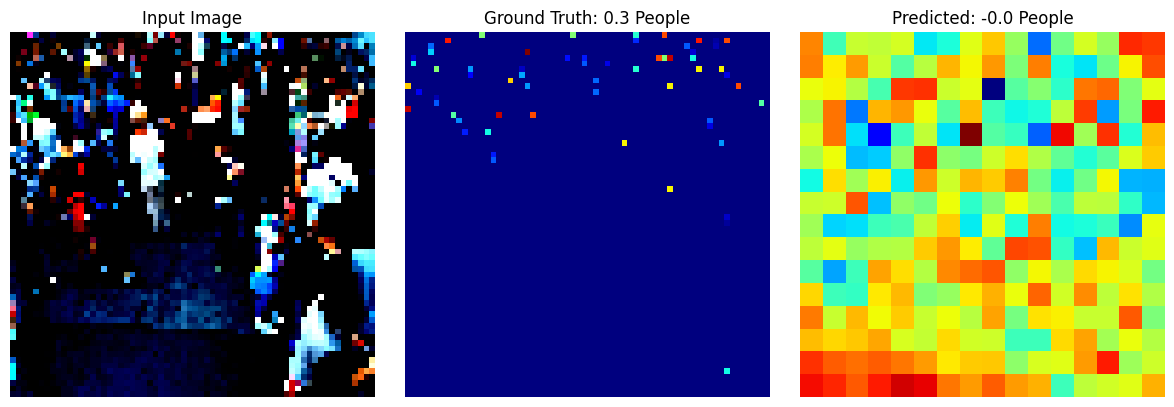

KeyboardInterrupt: 

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs, gt_maps in train_loader:
        imgs, gt_maps = imgs.to(device), gt_maps.to(device)
        preds = model(imgs)
        if preds.shape != gt_maps.shape:
            preds = F.interpolate(preds, size=gt_maps.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(preds, gt_maps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

    model.eval()
    with torch.no_grad():
        sample_img, sample_gt = next(iter(train_loader))
        sample_img, sample_gt = sample_img.to(device), sample_gt.to(device)
        pred_map = model(sample_img)
        plot(sample_img[0], sample_gt[0], pred_map[0].cpu())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].


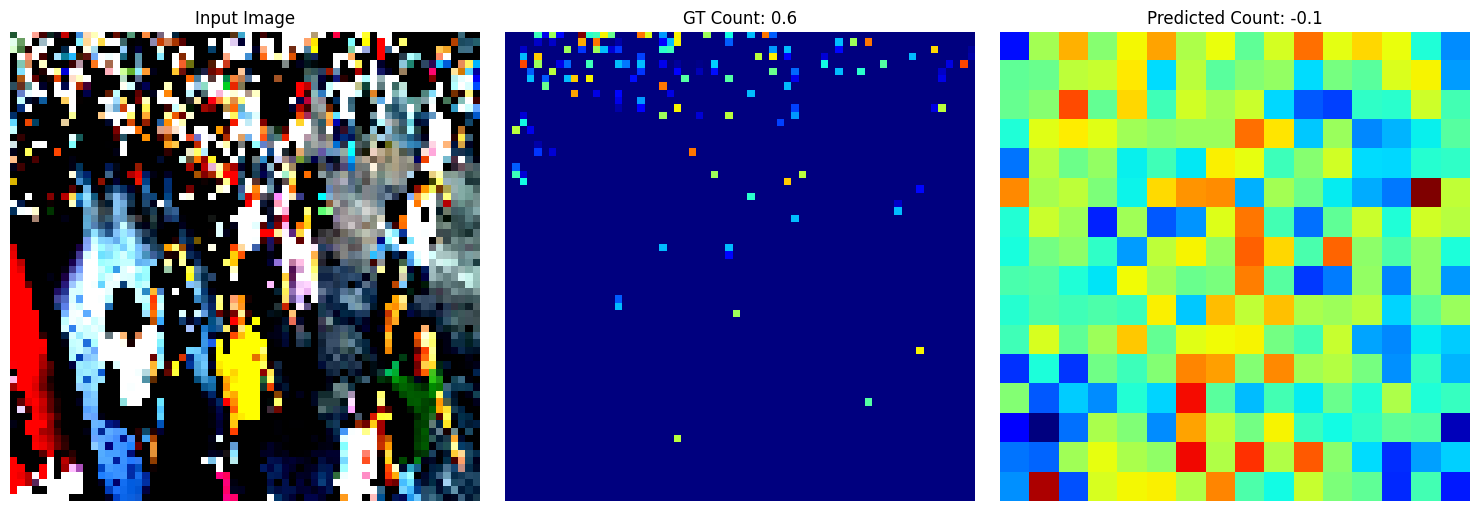

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


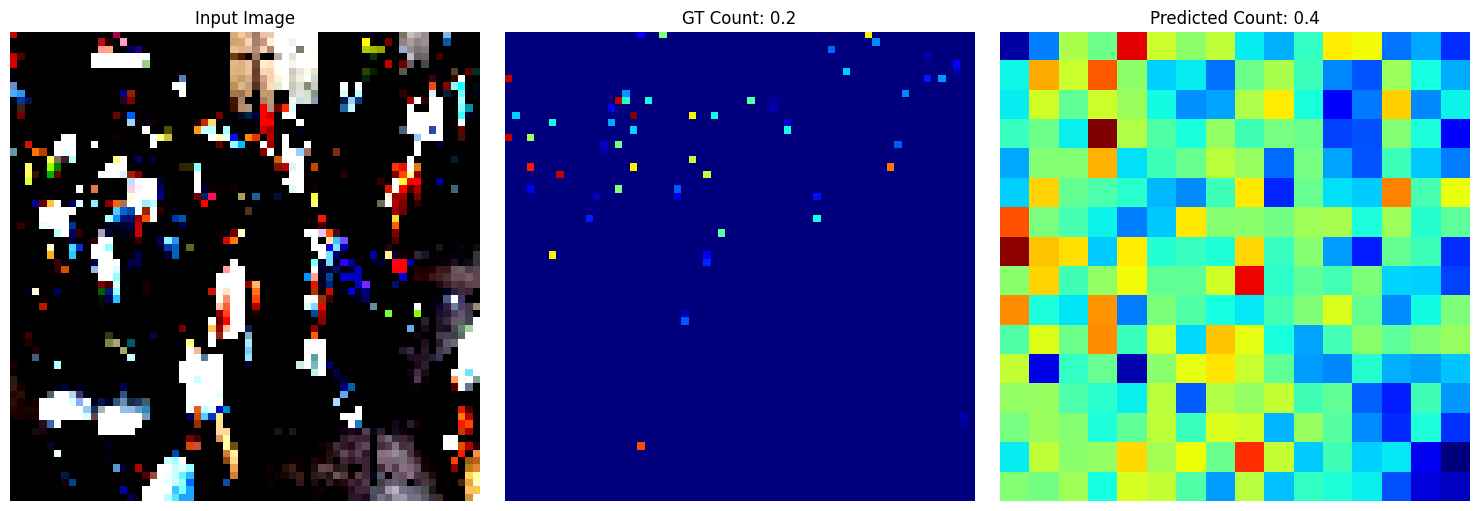

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.64].


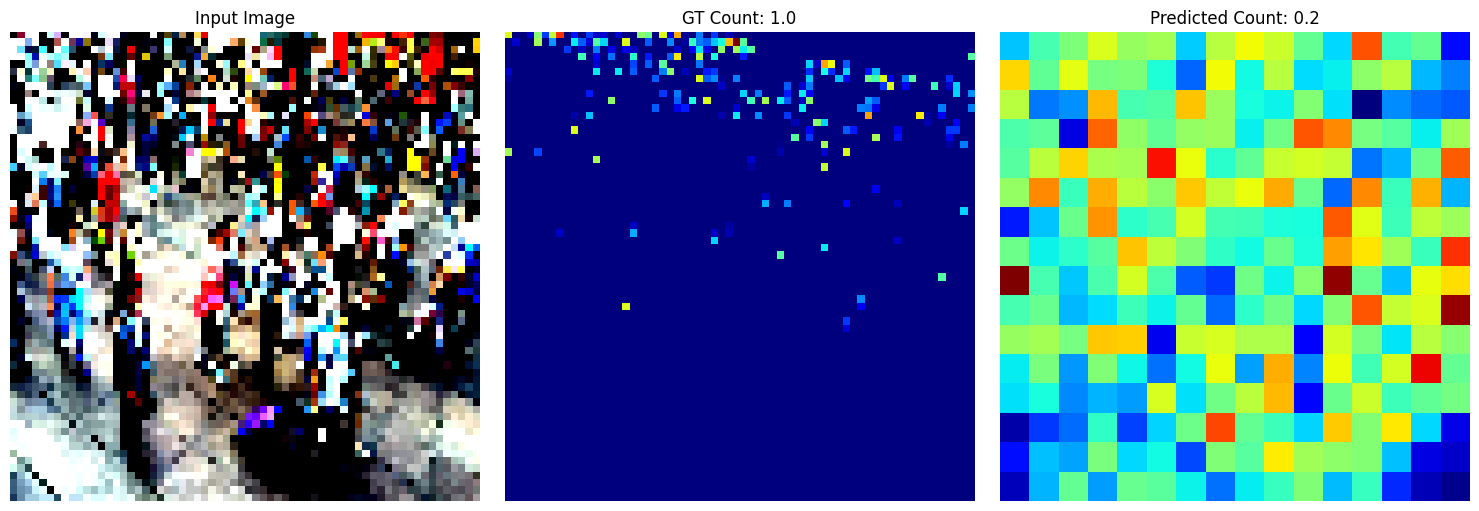

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


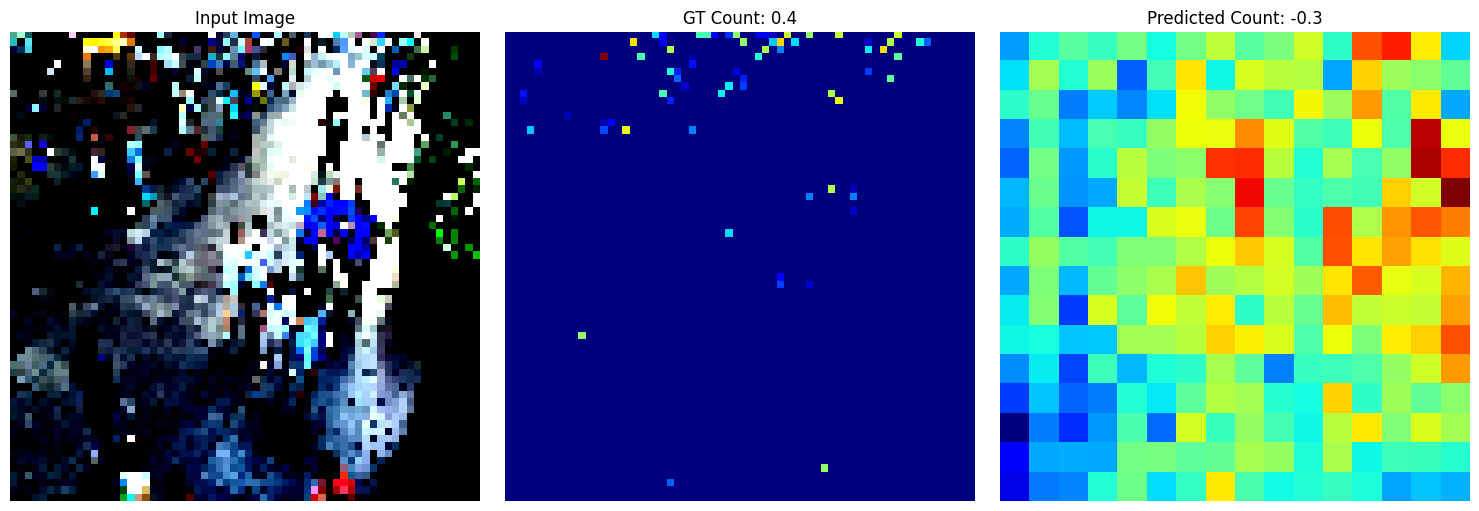

In [ ]:
model.eval()
with torch.no_grad():
    for imgs, gt_maps in test_loader:
        imgs, gt_maps = imgs.to(device), gt_maps.to(device)

        preds = model(imgs)

        for i in range(len(imgs)):
            gt_count = count_people_from_density(gt_maps[i])
            pred_count = count_people_from_density(preds[i])
            visualize_counting_result(imgs[i], gt_maps[i], preds[i], gt_count, pred_count)
        break  # Remove if you want to visualize more batches
